In [20]:
import sys
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

In [4]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [3]:
env = gym.make('CartPole-v0')
print(env.observation_space.shape)
print(env.action_space.n)

//anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(4,)
2


In [5]:
# if gpu is to be used
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
## Replay Memory
Transition = namedtuple("Transition", ("state", "action", "reward", "next_state", "done"))

class ReplayMemory(object):
    def __init__(self, maxlen):
        self.capacity = maxlen
        self.memory = list()
        self.position = 0
    
    def push(self, *args):
        """Saves Transition"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [7]:
class DQNEstimator(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNEstimator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, 32),
            nn.ReLU(),
            nn.Linear(32, 24),
            nn.ReLU(),
            nn.Linear(24, action_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [103]:
class Agent():
    def __init__(self, state_size, acion_size):
        self.state_size = state_size
        self.action_size = action_size
        
        # visualising training
        self.render = False
        self.load_model = False
        
        # hyperparams for estimator
        self.gamma = 0.99
        self.lr = 0.001
        self.replay_memory_size = 30000
        self.epsilon = 1.0
        self.min_epsilon = 0.01
        self.explore_steps = 4000
        self.epsilon_decay = (self.epsilon - self.min_epsilon) / self.explore_steps
        self.batch_size = 32
        self.replay_memory_init_size = 6000
        self.update_target_model_every = 1000
        
        # Replay Memory
        self.memory = ReplayMemory(self.replay_memory_size)
        
        # create estimator and target estimators
        self.q_estimator = DQNEstimator(state_size, action_size)
        self.target_estimator = DQNEstimator(state_size, action_size)
        self.optimizer = optim.Adam(self.q_estimator.parameters(), lr=self.lr)
        
        # initialize target estimator
        # TODO: copy q_estimator weights to target model
        
        if self.load_model:
            # TODO: Load saved Q estimator
            pass
        
    def update_target_estimator(self):
        self.target_estimator.load_state_dict(self.q_estimator.state_dict())
        
    def get_action(self, state):
        # random action
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:   # greedy action
            state = Variable(torch.from_numpy(state)).float()
            q_values = self.q_estimator(state)
            _, best_action = torch.max(q_values, dim=1)
            return int(best_action)
    
    def train_network(self):
        # TODO: epsilon decay
        if self.epsilon > self.min_epsilon:
            self.epsilon -= self.epsilon_decay
        
        # TODO: fetch samples
        samples = self.memory.sample(self.batch_size)
        samples = np.array(samples).transpose()
        
        # TODO: create batches of states, actions, rewards, next_states, done
        # stack all the states
        states = np.vstack(samples[0])
        actions = torch.LongTensor(list(samples[1]))
        rewards = torch.FloatTensor(list(samples[2]))
        next_states = Variable(torch.FloatTensor(np.vstack(samples[3])))
        is_dones = samples[4]
        
        is_dones = torch.FloatTensor(is_dones.astype(int))
        
        # TODO: forward propagation Q_network for current states
        states = torch.Tensor(states).float()
        preds = self.q_estimator(states)
        
        # TODO: onehot encoding actions
        actions_one_hot = F.one_hot(actions, num_classes=self.action_size)
        actions_one_hot = torch.FloatTensor(actions_one_hot.float())
        actions_one_hot = Variable(actions_one_hot)
        # TODO: get current actions' action value
        preds = torch.sum(torch.mul(preds, actions_one_hot), dim=1)
        
        # TODO: Q function of next state
        nex_state_preds = self.target_estimator(next_states).data
        
        # TODO: calculate Q-Learning target
        target = rewards + (1 - is_dones) * self.gamma * torch.max(nex_state_preds, dim=1)[0]
        target = Variable(target)
        
        # TODO: calculate mse loss (preds and targets)
        loss = F.mse_loss(preds, target).mean()
        
        # TODO: backward propagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

Total Steps: 83302	 Episode 500/500	 Loss: 1.51761722564697274Saved model


//anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DQNEstimator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


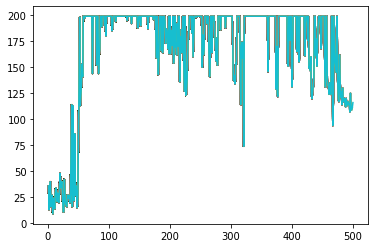

In [104]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = Agent(state_size, action_size)
scores, episodes = list(), list()

num_episodes = 500
total_steps = 0
state = env.reset()
state = np.reshape(state, [1, state_size])

flag = False
# populate replay memory
score = 0
for i in range(agent.replay_memory_init_size):
    action = agent.get_action(state)
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    reward = reward if not done or score == 499 else -10
    score += reward
    agent.memory.push(state, action, reward, next_state, done)
    if done:
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        score = 0
    else:
        state = next_state


for i_episode in range(1, num_episodes + 1):
    score = 0
    
    # update target network
    agent.update_target_estimator()
    
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    
    for t in count():
        if agent.render:
            env.render()
        
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        reward = reward if not done or score == 499 else -10
        
        agent.memory.push(state, action, reward, next_state, done)
        
        loss = agent.train_network()
        score += reward
        state = next_state
        
        if done:
            score = score if score==500 else score + 10
            scores.append(score)
            episodes.append(i_episode)
            plt.plot(episodes, scores, label="Scores vs Episode")
            plt.savefig("plots/cartpole_dqn.png")
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                torch.save(agent.q_estimator, "save_model/cartpole_dqn")
                print("Saved Model")
                flag = True
                sys.exit()
            break
        total_steps += 1
    print("\rTotal Steps: {}\t Episode {}/{}\t Loss: {}".format(total_steps, i_episode, num_episodes, loss), end="")
    sys.stdout.flush()

if not flag:
    torch.save(agent.q_estimator, "save_model/cartpole_dqn")
    print("Saved model")

In [105]:
max(scores)

199.0